# Portfolio Assginment: Text Classification 2

CS 4395.002 Human Language Technologies

Dr. Mazidi

Henry Kim HTK180000

## Overview
This Kaggle notebook uses deep learning approaches to classify headlines from the [Clickbait Dataset](https://www.kaggle.com/datasets/amananandrai/clickbait-dataset) as either clickbait or not clickbait.

https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

The dataset has 32,000 observations. Each observation has the article headline and the classification of 1 for clickbait and 0 for not clickbait.

In [77]:
# Import the libraries
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
import keras

# Load the train and test data 
dataset = pd.read_csv('../input/clickbait-dataset/clickbait_data.csv')

In [78]:
# Display some stats about the data and some datapoints
print('Shape: ' + str(dataset.shape) + '\n')
print('Classification ({}):'.format(len(dataset['clickbait'].unique())))
print(dataset['clickbait'].unique())
print()
print(dataset.head())

Shape: (32000, 2)

Classification (2):
[1 0]

                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1


The data is evenly split between examples of clickbait and non-clickbait headlines.

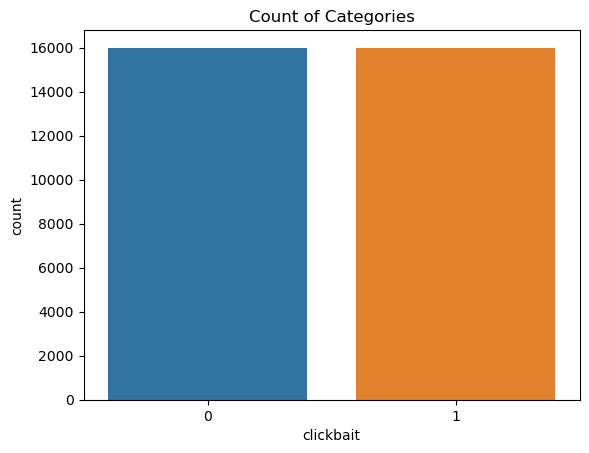

In [79]:
graph = sns.countplot(data=dataset, x='clickbait')
graph.set_xticklabels(graph.get_xticklabels())
plt.title("Count of Categories")
plt.show()

Let's preprocess the text by lowercasing everything and replacing all numbers with NUM.

In [80]:
X_dataset = dataset['headline']
y_dataset = dataset['clickbait']

print('Before preprocessing: ')
for x in X_dataset[:10]:
    print(x)

# Lowercase and remove punctuation
X_dataset = [re.sub(r'[^\w\s]', '', x).lower() for x in X_dataset]
# Replace all numbers with NUM
X_dataset = [re.sub(r'[0-9]+', 'num', x) for x in X_dataset]


print('\nAfter preprocessing: ')
for x in X_dataset[:10]:
    print(x)

Before preprocessing: 
Should I Get Bings
Which TV Female Friend Group Do You Belong In
The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills
This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect
A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor
How To Flirt With Queer Girls Without Making A Total Fool Of Yourself
32 Cute Things To Distract From Your Awkward Thanksgiving
If Disney Princesses Were From Florida
What's A Quote Or Lyric That Best Describes Your Depression
Natalie Dormer And Sam Claflin Play A Game To See How They'd Actually Last In "The Hunger Games"

After preprocessing: 
should i get bings
which tv female friend group do you belong in
the new star wars the force awakens trailer is here to give you chills
this vine of new york on celebrity big brother is fucking perfect
a couple did a stunning photo shoot with their baby after learning she had an inoperable brain tumor
how to flirt with q

In [81]:
# Split into train and test data
X_train_unfeaturized, X_test_unfeaturized, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=1234)
print(X_train_unfeaturized[:5])
print(y_train[:5])

['which marnie from halloweentown are you', 'aig sells its japanese headquarters for num billion', 'if disney princesses lived in canada', 'nasa schedules launch date for cometchasing probe', 'num times we were all princess eleanor from the royals']
13536    1
31326    0
14722    1
24503    0
9850     1
Name: clickbait, dtype: int64


The training text contains 21,755 unique tokens, but we will focus on the 20,000 most frequent since infrequent words may be things like celebrity names or brands. The longest headline in the training data is 26 words long, so we will set the maximum length of a headline to be 30.

In [82]:
# Count the unique words
all_train_text = ' '.join(X_train_unfeaturized)
all_train_words = all_train_text.split(' ')
unique_tokens = set(all_train_words)
vocab_size = len(unique_tokens)
print('Unique token count: ' + str(vocab_size))

# Find lengths of headlines 
headline_lengths = [len(x.split()) for x in X_train_unfeaturized]
max_headline_length = np.array(headline_lengths).max()
print('Most words in a headline: ' + str(max_headline_length))


vocab_size = 20000
max_length = 30

Unique token count: 21755
Most words in a headline: 26


## Sequential Neural Nets
For these basic sequential neural nets we will represent the website text as a bag of words using their tf-idf scores.

In [83]:
# Vectorize the text data using the top 20,000 words instead of all the words
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_unfeaturized)

X_train = tokenizer.texts_to_matrix(X_train_unfeaturized, mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test_unfeaturized, mode='tfidf')

# Display vectorized features
print('Feature vectors:')
print(X_train[:5])

Feature vectors:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.47633231 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.47633231 0.         ... 0.         0.         0.        ]]


## Attempt 3
This model uses a single hidden layer of 16 nodes with relu activation and an output layer that uses sigmoid activation.

In [84]:
# Build a sequential neural net
model = models.Sequential()
model.add(layers.Dense(16, input_dim=vocab_size,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())
 
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 16)                320016    
                                                                 
 dense_44 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 3s 17ms/step - loss: 0.2162 - accuracy: 0.9455 - val_loss: 0.0799 - val_accuracy: 0.9758
Epoch 2/15
180/180 [==============================] - 2s 12ms/step - loss: 0.0496 - accuracy: 0.9841 - val_loss: 0.0613 - val_accuracy: 0.9836
Epoch 3/15
180/180 [==============================] - 2s 12ms/step - loss: 0.0298 - accuracy: 0.9903 - val_loss: 0.0585 - val_accuracy: 0.9832
Epoch 4/1

## Attempt 2
This sequential neural net adds an embedding layer to reduce sparsity, but accuracy is drastically reduced.

In [85]:
# Build a sequential neural net
model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=vocab_size))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 20000, 8)          160000    
                                                                 
 flatten_8 (Flatten)         (None, 160000)            0         
                                                                 
 dense_45 (Dense)            (None, 16)                2560016   
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,720,033
Trainable params: 2,720,033
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 37s 201ms/step - loss: 0.6933 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 2/15
180/180 [=====

## Convolutional Neural Nets
For a CNN, order of the words matters since we are using a sliding window approach to the data. To preserve the ordering information we will use a TextVectorization layer as an encoder to map words to integers. Each observation will have its words converted to a list of integers representing a word with 0 padding the rest of the array for examples that have fewer words than the longest observed.

In [86]:
X_train = X_train_unfeaturized
X_test = X_test_unfeaturized

print('Unencoded observation example:')
print(X_train[0])

# Create the encoder layer
feature_encoder = layers.TextVectorization(max_tokens=vocab_size,  
                                                    output_sequence_length=max_length)
feature_encoder.adapt(X_train)

print('\nEncoded vocabulary example:')
vocab = np.array(feature_encoder.get_vocabulary())
print(vocab[:20])

encoded_example = feature_encoder(X_train)[0].numpy()
print('\nEncoded example:')
print(encoded_example)

print('\nConverting the first word of example back: ')
print(str(encoded_example[0]) + ': ' + vocab[encoded_example[0]])

Unencoded observation example:
which marnie from halloweentown are you

Encoded vocabulary example:
['' '[UNK]' 'num' 'to' 'in' 'the' 'of' 'you' 'a' 'for' 'and' 'on' 'your'
 'are' 'is' 'that' 'this' 'with' 'at' 'will']

Encoded example:
[  29 5975   21 3318   13    7    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Converting the first word of example back: 
29: which


### Attempt 1
This CNN model uses 1 convolutional layer and an embedding layer of size 8.

In [87]:
X_train = feature_encoder(X_train_unfeaturized)
X_test = feature_encoder(X_test_unfeaturized)

# Build a CNN
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 8, input_length=max_length)) 
model.add(layers.Conv1D(32, 7, activation='relu')) 
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 30, 8)             160000    
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 32)            1824      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 161,857
Trainable params: 161,857
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 2s 8ms/step - loss: 0.4877 - accuracy: 0.8368 - val_lo

### Attempt 2
This CNN model uses 1 convolutional layer and an embedding layer of size 16. The 4th root of the vocab size 20,000 is 11 which is between 8 and 16 (powers of 2 for best performance). However, increasing the embedding layer to the next size up doesn't improve accuracy.

In [88]:
X_train = feature_encoder(X_train_unfeaturized)
X_test = feature_encoder(X_test_unfeaturized)

# Build a CNN
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 16, input_length=max_length)) 
model.add(layers.Conv1D(32, 7, activation='relu')) 
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 30, 16)            320000    
                                                                 
 conv1d_6 (Conv1D)           (None, 24, 32)            3616      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_48 (Dense)            (None, 1)                 33        
                                                                 
Total params: 323,649
Trainable params: 323,649
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 2s 8ms/step - loss: 0.4234 - accuracy: 0.8706 - val_lo

## Recurrent Neural Nets
Like with CNNs, order of the words matters so we will use the same encoding scheme.

In [89]:
X_train = X_train_unfeaturized
X_test = X_test_unfeaturized

# Create the encoder layer
feature_encoder = layers.TextVectorization(max_tokens=vocab_size,  
                                                    output_sequence_length=max_length)
feature_encoder.adapt(X_train)

### Attempt 1
This model uses an embedding layer and 1 simple hidden RNN layer.

In [90]:
X_train = feature_encoder(X_train_unfeaturized)
X_test = feature_encoder(X_test_unfeaturized)

# Build an RNN
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 16, input_length=max_length))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 30, 16)            320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 321,601
Trainable params: 321,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 3s 12ms/step - loss: 0.3350 - accuracy: 0.8644 - val_loss: 0.2656 - val_accuracy: 0.8980
Epoch 2/15
180/180 [==============================] - 2s 11ms/step - loss: 0.1662 - accuracy: 0.9411 - val_loss: 0.1955 - val_accuracy: 0.9320
Epoch 3/15
180/180 [

### Attempt 2
This model uses a more powerful LSTM but gets similar results to the simple RNN

In [91]:
X_train = feature_encoder(X_train_unfeaturized)
X_test = feature_encoder(X_test_unfeaturized)

# Build an LSTM
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 16))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 16)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 326,305
Trainable params: 326,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 6s 23ms/step - loss: 0.5827 - accuracy: 0.6286 - val_loss: 0.2029 - val_accuracy: 0.9406
Epoch 2/15
180/180 [==============================] - 4s 20ms/step - loss: 0.1262 - accuracy: 0.9602 - val_loss: 0.0851 - val_accuracy: 0.9719
Epoch 3/15
180/180 [

### Attempt 3
This model uses a gated recurrent unit. The accuracy is surprisingly worse than the LSTM.

In [92]:
X_train = feature_encoder(X_train_unfeaturized)
X_test = feature_encoder(X_test_unfeaturized)

# Build a CNN
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 16, input_length=max_length))
model.add(layers.GRU(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

# Make predictions and check performance metrics
pred = model.predict(X_test)
pred_labels = [1 if p>= 0.5 else 0 for p in pred]
print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels, zero_division=0))

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 30, 16)            320000    
                                                                 
 gru_1 (GRU)                 (None, 32)                4800      
                                                                 
 dense_51 (Dense)            (None, 1)                 33        
                                                                 
Total params: 324,833
Trainable params: 324,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
180/180 [==============================] - 6s 21ms/step - loss: 0.6934 - accuracy: 0.4977 - val_loss: 0.6933 - val_accuracy: 0.4984
Epoch 2/15
180/180 [==============================] - 3s 18ms/step - loss: 0.6934 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 3/15
180/180 [

## Summary
All models performed well on this simple task except for the sequential neural network with an embedding layer and gated recurrent unit. For the sequential neural net this may be because the embedding used bag of words instead of maintaining data about the order of words. 